# OpenCV implementation

In [4]:
import cv2
import numpy as np
import os

def detect_number_plate(image):
    """
    Detect the number plate region in the image using color filtering.
    Returns the cropped number plate region or None if not found.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Red color range for private vehicle plates
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    # Combine two red ranges
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image, image, mask=mask)

    # Convert to grayscale and find contours
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)

        # Filter based on aspect ratio and size
        if 2 < aspect_ratio < 5 and w > 50 and h > 15:
            number_plate = image[y:y+h, x:x+w]
            return number_plate

    return None

def process_images(image_folder):
    """
    Process all images in a folder and detect number plates.
    """
    output_folder = "output"
    # Create output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(image_folder):
        filepath = os.path.join(image_folder, filename)

        try:
            image = cv2.imread(filepath)

            if image is None:
                print(f"Unable to load {filename}")
                continue

            plate = detect_number_plate(image)

            if plate is not None:
                print(f"Number plate detected in {filename}")
                # Save or process detected plate
                plate_output_path = os.path.join(output_folder, filename)
                cv2.imwrite(plate_output_path, plate)
            else:
                print(f"Number plate not detected in {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
process_images("./images/")


Number plate detected in 2024-03-08_1002_0.jpg
Number plate detected in 2024-03-08_1002_2.jpg
Number plate detected in 2024-03-08_1002_5.jpg
Number plate detected in 2024-03-08_1003_2.jpg
Number plate detected in 2024-03-08_1003_6.jpg
Number plate detected in 2024-03-08_1003_7.jpg
Number plate not detected in 2024-03-08_1005_0.jpg
Number plate detected in 2024-03-08_1006_3.jpg
Number plate detected in 2024-03-08_1006_4.jpg
Number plate detected in 2024-03-08_1006_8.jpg
Number plate not detected in 2024-03-08_1008_2.jpg
Number plate detected in 2024-03-08_1009_0.jpg
Number plate detected in 2024-03-08_1009_3.jpg
Number plate not detected in 2024-03-08_1009_5.jpg
Number plate not detected in 2024-03-08_1012_0.jpg
Number plate detected in 2024-03-08_1017_3.jpg
Number plate detected in 2024-03-08_1017_4.jpg
Number plate detected in 2024-03-08_1017_7.jpg
Number plate detected in 2024-03-08_1018_0.jpg
Number plate detected in 2024-03-08_1018_1.jpg
Number plate not detected in 2024-03-08_1018

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2  # 80% for training, 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    './NEPALI Number Plate Chars/',  # Path to your dataset
    target_size=(64, 64),  # Resize images to 64x64
    color_mode='grayscale',  # Load images as grayscale
    batch_size=32,  # Set batch size
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    './NEPALI Number Plate Chars/',  # Path to your dataset
    target_size=(64, 64),  # Resize images to 64x64
    color_mode='grayscale',  # Load images as grayscale
    batch_size=32,  # Set batch size
    class_mode='categorical',  # Multi-class classification
    subset='validation'  # Use 'validation' subset for validation data
)

# print("Training data classes:", train_generator.class_indices)
# print("Validation data classes:", validation_generator.class_indices)

## CNN Model

model = Sequential([
    Input(shape=(64, 64, 1)),  # Grayscale images of size 64x64
    Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer
    MaxPooling2D((2, 2)),  # MaxPooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
    MaxPooling2D((2, 2)),  # Second MaxPooling layer
    Flatten(),  # Flatten the output
    Dense(128, activation='relu'),  # Fully connected layer
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer for number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model
model.save('deva_character_recognition_model.h5')


2024-12-01 23:18:45.924785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 23:18:47.114171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 1631 images belonging to 12 classes.
Found 402 images belonging to 12 classes.


2024-12-01 23:18:48.523269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-01 23:18:49.273704: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Train the model with the train and validation generators
history = model.fit(
    train_generator,
    epochs=10,  # Number of epochs to train
    validation_data=validation_generator
)

Epoch 1/10


/home/tckleme-dev/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.1267 - loss: 2.4898 - val_accuracy: 0.2488 - val_loss: 2.2373
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.4183 - loss: 1.9822 - val_accuracy: 0.6667 - val_loss: 1.1480
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7021 - loss: 1.0476 - val_accuracy: 0.7711 - val_loss: 0.8528
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.7976 - loss: 0.8044 - val_accuracy: 0.7910 - val_loss: 0.7445
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8325 - loss: 0.6305 - val_accuracy: 0.8060 - val_loss: 0.6805
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8770 - loss: 0.4700 - val_accuracy: 0.8358 - val_loss: 0.5861
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9057 - loss: 0.4007 - val_accuracy: 0.8582 - val_loss: 0.5373
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9388 - loss: 0.2917 - val_accuracy: 0.8408 - val_loss: 

In [7]:
# import tensorflow as tf
# import cv2
# import numpy as np
# import os

# Load the trained CNN model
model = tf.keras.models.load_model('deva_character_recognition_model.h5')

# Function to preprocess and predict character
def predict_character(cropped_char_img):
    """
    Predict the character from the cropped character image.
    """
    # Resize and preprocess the image
    img = cv2.cvtColor(cropped_char_img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0  # Normalize
    img = img.reshape(1, 64, 64, 1)  # Reshape for the model
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    return predicted_class

def process_detected_number_plate(plate_img):
    """
    Process the detected number plate and predict each character.
    """
    # Preprocess the image: convert to grayscale, apply threshold, etc.
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours for each character
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    plate_text = ""
    
    # For each contour, extract the character
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filter based on character size
        if w > 5 and h > 10:
            char_img = plate_img[y:y+h, x:x+w]
            predicted_char = predict_character(char_img)
            plate_text += str(predicted_char)

    print(f"Detected Text: {plate_text}")
    return plate_text

plate_image = cv2.imread('./output/2024-03-08_359_3.jpg')
detected_text = process_detected_number_plate(plate_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Detected Text: 1010


In [8]:
# Full pipeline: Detect number plate and recognize characters
def full_pipeline(image_folder):
    output_folder = "output"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(image_folder):
        filepath = os.path.join(image_folder, filename)

        try:
            image = cv2.imread(filepath)

            if image is None:
                print(f"Unable to load {filename}")
                continue

            # Step 1: Detect number plate
            plate = detect_number_plate(image)

            if plate is not None:
                print(f"Number plate detected in {filename}")
                # Step 2: Process detected plate and predict characters
                detected_text = process_detected_number_plate(plate)

                # Save or process detected plate if needed
                plate_output_path = os.path.join(output_folder, filename)
                cv2.imwrite(plate_output_path, plate)
            else:
                print(f"Number plate not detected in {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
full_pipeline("./output/")


Number plate detected in 2024-03-08_1002_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Detected Text: 9
Number plate detected in 2024-03-08_1002_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Detected Text: 911
Number plate not detected in 2024-03-08_1002_5.jpg
Number plate detected in 2024-03-08_1003_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Detected Text: 4
Number plate detected in 2024-03-08_1003_6.jpg
Detected Text: 
Number plate detected in 2024-03-08_1003_7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Detected Text: 10
Number plate detected in 2024-03-08_1006_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Detected Text: 10
Number plate detected in 2024-03-08_1006_4.jpg
Detected Text: 
Number plate not detected in 2024-03-08_1006_8.jpg
Number plate detected in 2024-03-08_1009_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Detected Text: 10
Number plate not detected in 2024-03-08_1009_3.jpg
Number plate not detected in 2024-03-08_1017_3.jpg
Number plate no

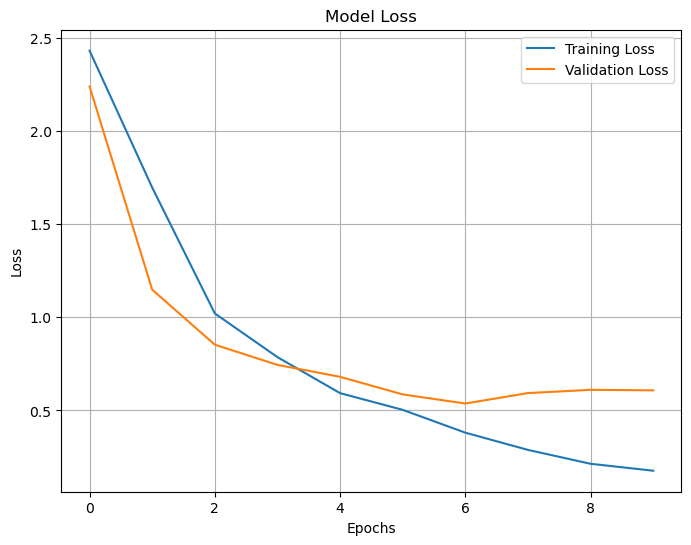

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step


/home/tckleme-dev/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tckleme-dev/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tckleme-dev/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        37
           4       0.27      0.07      0.12        41
           5       0.00      0.00      0.00        38
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00        27
           9       0.09      0.21      0.12        24
          ba       0.10      0.76      0.17        41
          pa       0.00      0.00      0.00        46

    accuracy                           0.10       402
   macro avg       0.04      0.09      0.03       402
weighted avg       0.04      0.10      0.04       402

Precision: 0.04266058881889187
Recall: 0.09701492537313433
F1 Score: 0.03627867914620171


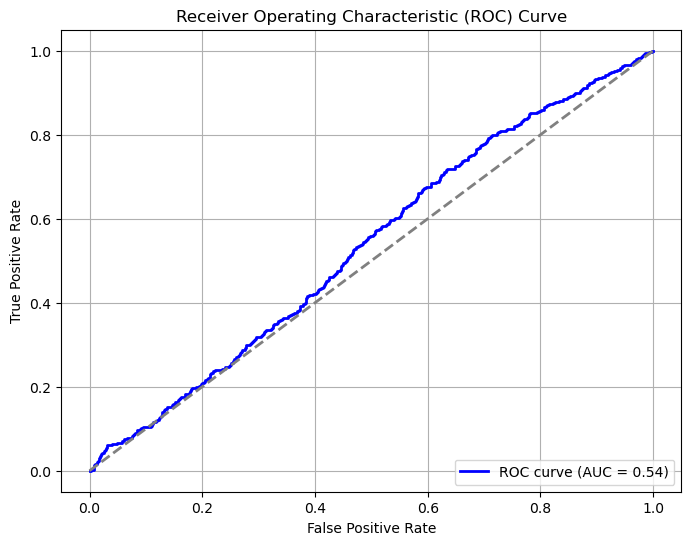

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Plot training & validation loss values
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Get the labels from the validation generator
true_labels = validation_generator.classes

# Predict the classes for the validation data
predictions = model.predict(validation_generator, verbose=1)

# Get the predicted class index by finding the maximum probability
predicted_classes = np.argmax(predictions, axis=1)

# Generate a classification report
report = classification_report(true_labels, predicted_classes, target_names=validation_generator.class_indices.keys())
print(report)

# Calculate precision, recall, and F1 score using sklearn's metrics
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Binarize the labels for multi-class AUC calculation
true_labels_bin = label_binarize(true_labels, classes=np.arange(len(validation_generator.class_indices)))

# Compute AUC-ROC curve
fpr, tpr, thresholds = roc_curve(true_labels_bin.ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

# Plot AUC-ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import classification_report
import numpy as np

# Get the labels from the validation generator
true_labels = validation_generator.classes

# Predict the classes for the validation data
predictions = model.predict(validation_generator, verbose=1)

# Get the predicted class index by finding the maximum probability
predicted_classes = np.argmax(predictions, axis=1)

# Generate a classification report
report = classification_report(true_labels, predicted_classes, target_names=validation_generator.class_indices.keys())

# Print the classification report
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        37
           4       0.09      0.02      0.04        41
           5       0.00      0.00      0.00        38
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00        27
           9       0.05      0.12      0.07        24
          ba       0.09      0.73      0.16        41
          pa       0.00      0.00      0.00        46

    accuracy                           0.08       402
   macro avg       0.02      0.07      0.02       402
weighted avg       0.02      0.08      0.02       402



/home/tckleme-dev/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tckleme-dev/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tckleme-dev/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera